# Code optimisé pour la reconnaissance de races de chiens - Apprentissage rapide

In [ ]:
!pip install tensorflow

# Imports nécessaires
import os
import shutil
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import TopKCategoricalAccuracy

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# Pour équilibre optimal vitesse/performance
TARGET_SIZE = (180, 180)
BATCH_SIZE = 96
NUM_CLASSES = 120
EPOCHS = 40

print(f"Configuration:")
print(f"- Taille images: {TARGET_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Epochs max: {EPOCHS}")

Configuration:
- Taille images: (180, 180)
- Batch size: 96
- Epochs max: 40


In [ ]:
# Extraction et configuration des chemins
base_dir = '/content/'
os.chdir(base_dir)

# Extraction du dataset si nécessaire
if not os.path.exists('train'):
    zip_ref = zipfile.ZipFile('/content/dog-breed-identification.zip', 'r')
    zip_ref.extractall('/content')
    zip_ref.close()
    print("Dataset extrait avec succès")

# Chemins des dossiers
original_train_dir = 'train'
train_subset_dir = 'train_fast'
val_subset_dir = 'val_fast'

os.makedirs(train_subset_dir, exist_ok=True)
os.makedirs(val_subset_dir, exist_ok=True)

Dataset extrait avec succès


In [ ]:
# Lecture et préparation des données avec sous-échantillonnage
labels_df = pd.read_csv('labels.csv')
labels_df['filename'] = labels_df['id'] + '.jpg'

print(f"Dataset original: {len(labels_df)} images")
print(f"Nombre de races: {labels_df['breed'].nunique()}")

# Sous-échantillonnage pour accélérer: max 50 images par race
""""""
sampled_df = labels_df.groupby('breed').apply(
    lambda x: x.sample(min(len(x), 100), random_state=42)
).reset_index(drop=True)


print(f"Dataset réduit: {len(sampled_df)} images")
print(f"Réduction: {len(sampled_df)/len(labels_df)*100:.1f}%")

Dataset original: 10222 images
Nombre de races: 120
Dataset réduit: 10038 images
Réduction: 98.2%


/tmp/ipython-input-692204124.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = labels_df.groupby('breed').apply(


In [ ]:
# Split train/validation stratifié
train_df, val_df = train_test_split(
    sampled_df,
    test_size=0.10,
    stratify=sampled_df['breed'],
    random_state=42
)

print(f"Split des données:")
print(f"- Train: {len(train_df)} images")
print(f"- Validation: {len(val_df)} images")

Split des données:
- Train: 9034 images
- Validation: 1004 images


In [ ]:
# Copie rapide des images dans les dossiers appropriés
print("Copie des images...")

# Copie train
train_copied = 0
for idx, row in train_df.iterrows():
    src = os.path.join(original_train_dir, row['filename'])
    dst = os.path.join(train_subset_dir, row['filename'])
    if os.path.exists(src) and not os.path.exists(dst):
        shutil.copy2(src, dst)
        train_copied += 1

# Copie validation
val_copied = 0
for idx, row in val_df.iterrows():
    src = os.path.join(original_train_dir, row['filename'])
    dst = os.path.join(val_subset_dir, row['filename'])
    if os.path.exists(src) and not os.path.exists(dst):
        shutil.copy2(src, dst)
        val_copied += 1

print(f"Images copiées - Train: {train_copied}, Val: {val_copied}")

Copie des images...
Images copiées - Train: 9034, Val: 1004


In [ ]:
# Générateurs de données optimisés pour la vitesse
# Augmentation simplifiée pour réduire le temps de calcul
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Validation sans augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

print("Générateurs de données créés")

Générateurs de données créés


In [ ]:
# Création des générateurs à partir des DataFrames
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_subset_dir,
    x_col='filename',
    y_col='breed',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_subset_dir,
    x_col='filename',
    y_col='breed',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print(f"Générateurs prêts:")
print(f"- Steps train par epoch: {len(train_gen)}")
print(f"- Steps validation: {len(val_gen)}")

Found 9034 validated image filenames belonging to 120 classes.
Found 1004 validated image filenames belonging to 120 classes.
Générateurs prêts:
- Steps train par epoch: 95
- Steps validation: 11


In [ ]:
# Architecture CNN optimisée pour vitesse et performance
inputs = layers.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# Bloc 1 - Extraction rapide des features
x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Bloc 2 - Features intermédiaires
x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.25)(x)

# Bloc 3 - Features complexes
x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.25)(x)

# Bloc 4 - Features finales
x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)

# Pooling global et classification
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

cnn_model = Model(inputs, outputs, name='OptimizedCNN')

# Compilation avec métriques
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

print("Architecture CNN optimisée:")
cnn_model.summary()

Architecture CNN optimisée:


Model: "OptimizedCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 90, 90, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 583,480 (2.23 MB)

 Trainable params: 582,520 (2.22 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callbacks pour optimiser l'entraînement
cnn_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_cnn_optimized.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configurés pour l'optimisation")

Callbacks configurés pour l'optimisation


In [ ]:
# Entraînement du modèle CNN optimisé
print("Début entraînement CNN optimisé")

cnn_history = cnn_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=cnn_callbacks,
    verbose=1,

)

print("Entraînement CNN terminé")

Début entraînement CNN optimisé


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0094 - loss: 4.8352 - top_5_accuracy: 0.0515
Epoch 1: val_accuracy improved from -inf to 0.01394, saving model to best_cnn_optimized.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 414s 4s/step - accuracy: 0.0094 - loss: 4.8348 - top_5_accuracy: 0.0515 - val_accuracy: 0.0139 - val_loss: 4.7969 - val_top_5_accuracy: 0.0428 - learning_rate: 0.0010
Epoch 2/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0137 - loss: 4.7444 - top_5_accuracy: 0.0721
Epoch 2: val_accuracy improved from 0.01394 to 0.01793, saving model to best_cnn_optimized.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.0137 - loss: 4.7443 - top_5_accuracy: 0.0722 - val_accuracy: 0.0179 - val_loss: 4.8585 - val_top_5_accuracy: 0.0558 - learning_rate: 0.0010
Epoch 3/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0247 - loss: 4.6775 - top_5_accuracy: 0.0930
Epoch 3: val_accuracy did not improve from 0.01793
95/95 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - accuracy: 0.0247 - loss: 4.6774 - top_5_accuracy: 0.0930 - val_accuracy: 0.0110 - val_loss: 4.9509 - val_top_5_accuracy: 0.0558 - learning_rate: 0.0010
Epoch 4/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0263 - loss: 4.6221 - top_5_accuracy: 0.1065
Epoch 4: val_accuracy did not improve from 0.01793
95/95 ━━━━━━━━━━━━━━━━━━━━ 409s 4s/step - accuracy: 0.0263 - loss: 4.6219 - top_5_accuracy: 0.1065 - val_accuracy: 0.0159 - val_loss: 4.9084 - val_top_5_accuracy: 0.0787 - learning_rate: 0.0010
Epoch 5/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0295 - loss: 4.5709 - top_5_accuracy:

95/95 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.0295 - loss: 4.5708 - top_5_accuracy: 0.1209 - val_accuracy: 0.0369 - val_loss: 4.6375 - val_top_5_accuracy: 0.1076 - learning_rate: 0.0010
Epoch 6/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0304 - loss: 4.5223 - top_5_accuracy: 0.1240
Epoch 6: val_accuracy did not improve from 0.03685
95/95 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.0304 - loss: 4.5222 - top_5_accuracy: 0.1241 - val_accuracy: 0.0179 - val_loss: 4.7957 - val_top_5_accuracy: 0.0936 - learning_rate: 0.0010
Epoch 7/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0361 - loss: 4.4553 - top_5_accuracy: 0.1416
Epoch 7: val_accuracy did not improve from 0.03685
95/95 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.0361 - loss: 4.4554 - top_5_accuracy: 0.1416 - val_accuracy: 0.0359 - val_loss: 4.5884 - val_top_5_accuracy: 0.1235 - learning_rate: 0.0010
Epoch 8/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0432 - loss: 4.4051 - top_5_accuracy:

95/95 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - accuracy: 0.0461 - loss: 4.3555 - top_5_accuracy: 0.1747 - val_accuracy: 0.0428 - val_loss: 4.4490 - val_top_5_accuracy: 0.1643 - learning_rate: 3.0000e-04
Epoch 10/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0560 - loss: 4.3162 - top_5_accuracy: 0.1912
Epoch 10: val_accuracy did not improve from 0.04283
95/95 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.0560 - loss: 4.3161 - top_5_accuracy: 0.1912 - val_accuracy: 0.0378 - val_loss: 4.6428 - val_top_5_accuracy: 0.1384 - learning_rate: 3.0000e-04
Epoch 11/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0566 - loss: 4.2650 - top_5_accuracy: 0.2010
Epoch 11: val_accuracy improved from 0.04283 to 0.05578, saving model to best_cnn_optimized.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 390s 4s/step - accuracy: 0.0566 - loss: 4.2652 - top_5_accuracy: 0.2009 - val_accuracy: 0.0558 - val_loss: 4.3665 - val_top_5_accuracy: 0.1882 - learning_rate: 3.0000e-04
Epoch 12/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0606 - loss: 4.2410 - top_5_accuracy: 0.2148
Epoch 12: val_accuracy improved from 0.05578 to 0.06076, saving model to best_cnn_optimized.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.0606 - loss: 4.2412 - top_5_accuracy: 0.2148 - val_accuracy: 0.0608 - val_loss: 4.3296 - val_top_5_accuracy: 0.1982 - learning_rate: 3.0000e-04
Epoch 13/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0643 - loss: 4.2413 - top_5_accuracy: 0.2128
Epoch 13: val_accuracy did not improve from 0.06076
95/95 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.0643 - loss: 4.2413 - top_5_accuracy: 0.2128 - val_accuracy: 0.0568 - val_loss: 4.3059 - val_top_5_accuracy: 0.1942 - learning_rate: 3.0000e-04
Epoch 14/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0622 - loss: 4.2216 - top_5_accuracy: 0.2227
Epoch 14: val_accuracy did not improve from 0.06076
95/95 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - accuracy: 0.0622 - loss: 4.2215 - top_5_accuracy: 0.2227 - val_accuracy: 0.0548 - val_loss: 4.3583 - val_top_5_accuracy: 0.1703 - learning_rate: 3.0000e-04
Epoch 15/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0668 - loss: 4.1906 

95/95 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.0690 - loss: 4.1593 - top_5_accuracy: 0.2344 - val_accuracy: 0.0667 - val_loss: 4.2264 - val_top_5_accuracy: 0.2112 - learning_rate: 9.0000e-05
Epoch 17/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0799 - loss: 4.1243 - top_5_accuracy: 0.2469
Epoch 17: val_accuracy did not improve from 0.06673
95/95 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - accuracy: 0.0799 - loss: 4.1245 - top_5_accuracy: 0.2469 - val_accuracy: 0.0637 - val_loss: 4.2465 - val_top_5_accuracy: 0.2082 - learning_rate: 9.0000e-05
Epoch 18/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0699 - loss: 4.1346 - top_5_accuracy: 0.2456
Epoch 18: val_accuracy improved from 0.06673 to 0.06873, saving model to best_cnn_optimized.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.0699 - loss: 4.1345 - top_5_accuracy: 0.2456 - val_accuracy: 0.0687 - val_loss: 4.2497 - val_top_5_accuracy: 0.2161 - learning_rate: 9.0000e-05
Epoch 19/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0739 - loss: 4.1281 - top_5_accuracy: 0.2436
Epoch 19: val_accuracy improved from 0.06873 to 0.06972, saving model to best_cnn_optimized.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 439s 4s/step - accuracy: 0.0740 - loss: 4.1281 - top_5_accuracy: 0.2436 - val_accuracy: 0.0697 - val_loss: 4.2213 - val_top_5_accuracy: 0.2281 - learning_rate: 9.0000e-05
Epoch 20/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0731 - loss: 4.1192 - top_5_accuracy: 0.2524
Epoch 20: val_accuracy did not improve from 0.06972
95/95 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.0731 - loss: 4.1192 - top_5_accuracy: 0.2524 - val_accuracy: 0.0667 - val_loss: 4.2366 - val_top_5_accuracy: 0.2191 - learning_rate: 9.0000e-05
Epoch 21/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0803 - loss: 4.1111 - top_5_accuracy: 0.2497
Epoch 21: val_accuracy did not improve from 0.06972
95/95 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.0803 - loss: 4.1111 - top_5_accuracy: 0.2497 - val_accuracy: 0.0618 - val_loss: 4.2375 - val_top_5_accuracy: 0.2151 - learning_rate: 9.0000e-05
Epoch 22/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0766 - loss: 4.1021 

In [ ]:
# Évaluation du modèle CNN
cnn_results = cnn_model.evaluate(val_gen, verbose=0)
print("Évaluation du modèle CNN:")
print(cnn_model.metrics_names)

cnn_metrics = cnn_model.metrics_names
cnn_loss = cnn_results[0]
# Correction: utiliser l'index 1 pour l'accuracy car c'est la deuxième métrique
cnn_accuracy = cnn_results[1] if len(cnn_results) > 1 else None
cnn_top5 = cnn_results[2] if len(cnn_results) > 2 else None

print(f"CNN - Loss: {cnn_loss:.4f}")
if cnn_accuracy:
    print(f"CNN - Accuracy: {cnn_accuracy:.4f}")
if cnn_top5:
    print(f"CNN - Top-5 Accuracy: {cnn_top5:.4f}")

Évaluation du modèle CNN:
['loss', 'compile_metrics']
CNN - Loss: 4.2213
CNN - Accuracy: 0.0697
CNN - Top-5 Accuracy: 0.2281


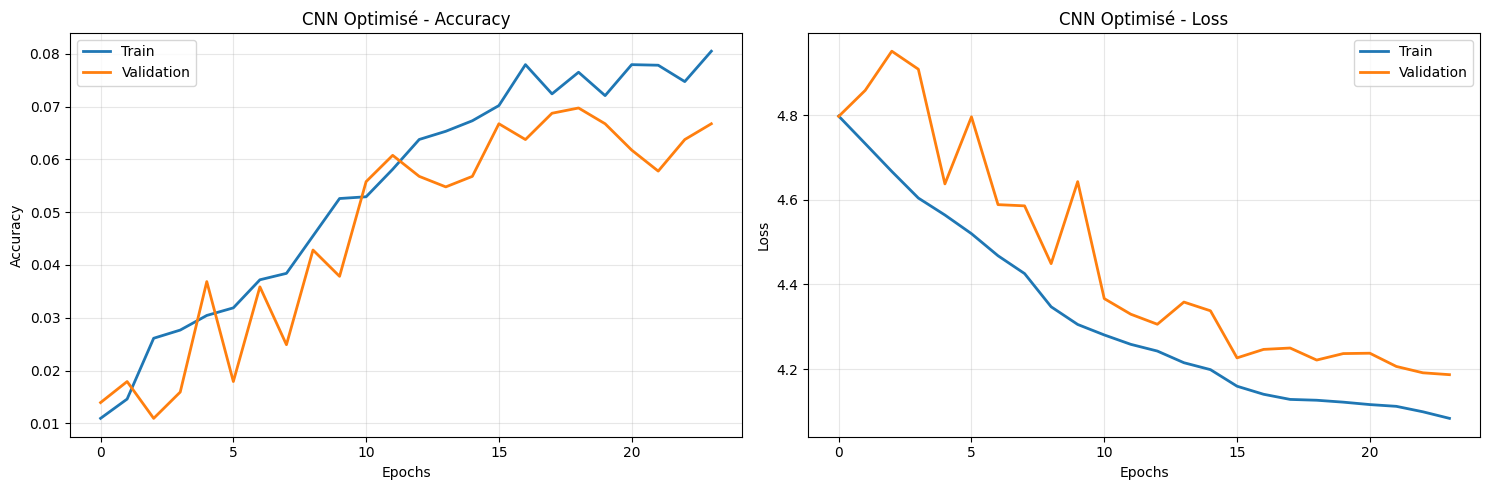

In [ ]:
# Visualisation des résultats CNN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(cnn_history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(cnn_history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('CNN Optimisé - Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(cnn_history.history['loss'], label='Train', linewidth=2)
ax2.plot(cnn_history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('CNN Optimisé - Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Transfer Learning avec EfficientNetB0 (plus rapide)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
)

# Gel partiel pour accélérer (gel des couches de base)
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Head personnalisé léger
inputs = base_model.input
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

transfer_model = Model(inputs, outputs, name='OptimizedEfficientNet')

# Compilation
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

print("Transfer Learning modèle créé:")
print(f"Couches totales: {len(transfer_model.layers)}")
trainable_layers = sum(1 for layer in transfer_model.layers if layer.trainable)
print(f"Couches entraînables: {trainable_layers}")

Transfer Learning modèle créé:
Couches totales: 243
Couches entraînables: 25


In [ ]:
# Callbacks pour Transfer Learning
transfer_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_transfer_optimized.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks Transfer Learning configurés")

Callbacks Transfer Learning configurés


In [ ]:
# Entraînement Transfer Learning
print("Début entraînement Transfer Learning")

transfer_history = transfer_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=transfer_callbacks,
    verbose=1
)

print("Entraînement Transfer Learning terminé")

Début entraînement Transfer Learning
Epoch 1/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0073 - loss: 4.8326 - top_5_accuracy: 0.0397
Epoch 1: val_accuracy improved from -inf to 0.00996, saving model to best_transfer_optimized.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 692s 7s/step - accuracy: 0.0073 - loss: 4.8324 - top_5_accuracy: 0.0398 - val_accuracy: 0.0100 - val_loss: 4.7982 - val_top_5_accuracy: 0.0468 - learning_rate: 0.0010
Epoch 2/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0119 - loss: 4.7921 - top_5_accuracy: 0.0475
Epoch 2: val_accuracy did not improve from 0.00996
95/95 ━━━━━━━━━━━━━━━━━━━━ 693s 7s/step - accuracy: 0.0119 - loss: 4.7921 - top_5_accuracy: 0.0475 - val_accuracy: 0.0100 - val_loss: 4.7854 - val_top_5_accuracy: 0.0528 - learning_rate: 0.0010
Epoch 3/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0111 - loss: 4.7867 - top_5_accuracy: 0.0445
Epoch 3: val_accuracy did not improve from 0.00996
95/95 ━━━━━━━━━━━━━━━━━━━━ 674s 7s/step - accuracy: 0.0111 - loss: 4.7867 - top_5_accuracy: 0.0445 - val_accuracy: 0.0100 - val_loss: 4.7847 - val_top_5_accuracy: 0.0498 - learning_rate: 0.0010
Epoch 4/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0111 - loss: 4.7851 - top_5_accuracy:

In [ ]:
# Évaluation du modèle Transfer Learning
transfer_results = transfer_model.evaluate(val_gen, verbose=0)
print("Évaluation du modèle Transfer Learning:")
print(transfer_model.metrics_names)

transfer_metrics = transfer_model.metrics_names
transfer_loss = transfer_results[0]
# Correction: utiliser l'index 1 pour l'accuracy car c'est la deuxième métrique
transfer_accuracy = transfer_results[1] if len(transfer_results) > 1 else None
transfer_top5 = transfer_results[2] if len(transfer_results) > 2 else None

print(f"Transfer Learning - Loss: {transfer_loss:.4f}")
if transfer_accuracy:
    print(f"Transfer Learning - Accuracy: {transfer_accuracy:.4f}")
if transfer_top5:
    print(f"Transfer Learning - Top-5 Accuracy: {transfer_top5:.4f}")


Évaluation du modèle Transfer Learning:
['loss', 'compile_metrics']
Transfer Learning - Loss: 4.7982
Transfer Learning - Accuracy: 0.0100
Transfer Learning - Top-5 Accuracy: 0.0468


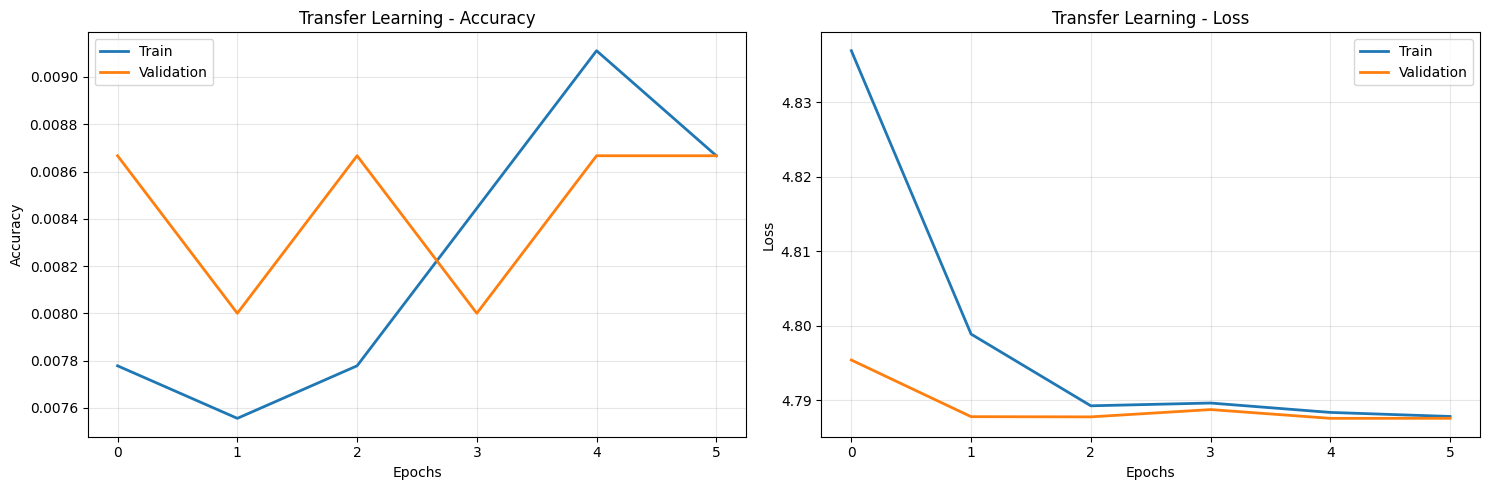

In [ ]:
# Visualisation des résultats Transfer Learning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(transfer_history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(transfer_history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Transfer Learning - Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(transfer_history.history['loss'], label='Train', linewidth=2)
ax2.plot(transfer_history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Transfer Learning - Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Comparaison des modèles
print("COMPARAISON DES MODÈLES")
print("=" * 50)
print(f"CNN Optimisé:")
print(f"  - Accuracy: {cnn_accuracy*100:.2f}%")
if cnn_top5:
    print(f"  - Top-5: {cnn_top5*100:.2f}%")
print()
print(f"Transfer Learning (EfficientNetB0):")
print(f"  - Accuracy: {transfer_accuracy*100:.2f}%")
if transfer_top5:
    print(f"  - Top-5: {transfer_top5*100:.2f}%")

# Déterminer le meilleur modèle
best_model_name = "Transfer Learning" if transfer_accuracy > cnn_accuracy else "CNN Optimisé"
best_model = transfer_model if transfer_accuracy > cnn_accuracy else cnn_model

print(f"\nMeilleur modèle: {best_model_name}")

COMPARAISON DES MODÈLES
CNN Optimisé:
  - Accuracy: 6.00%
  - Top-5: 20.33%

Transfer Learning (EfficientNetB0):
  - Accuracy: 0.87%
  - Top-5: 4.07%

Meilleur modèle: CNN Optimisé


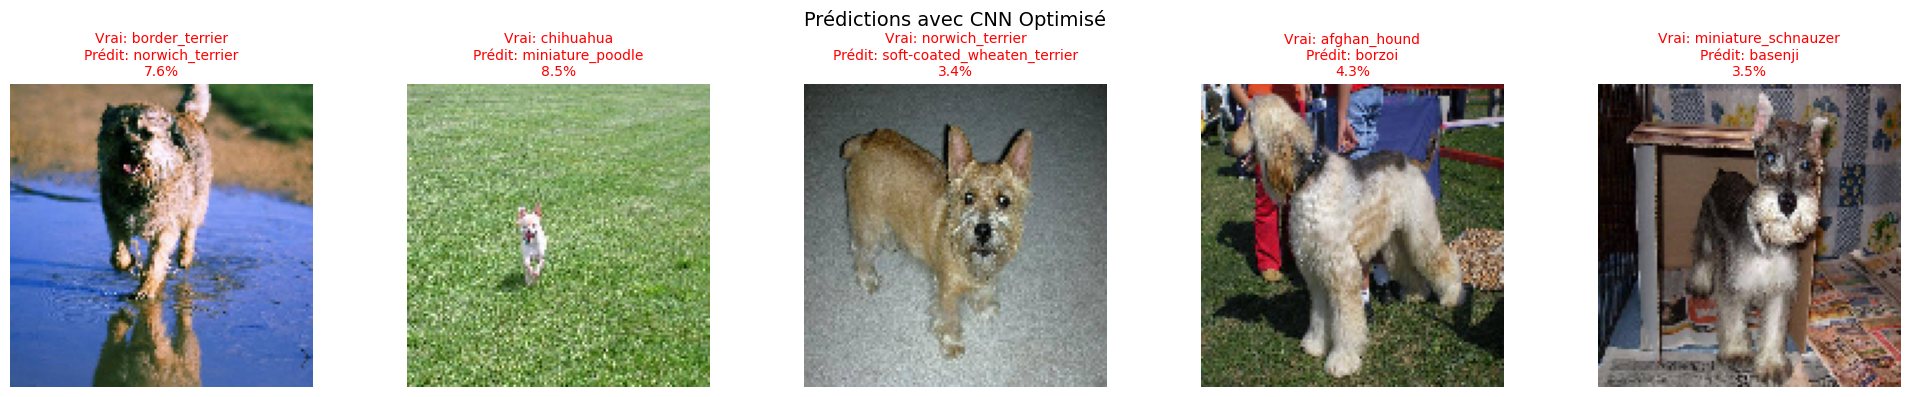

In [ ]:
# Test de prédiction rapide sur quelques échantillons
# Obtenir un batch de validation
images, true_labels = next(val_gen)
num_samples = 5

# Prédictions avec le meilleur modèle
predictions = best_model.predict(images[:num_samples], verbose=0)

# Noms des classes
class_names = list(val_gen.class_indices.keys())

# Affichage des résultats
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))

for i in range(num_samples):
    # Image
    axes[i].imshow(images[i])
    axes[i].axis('off')

    # Vraie classe
    true_class_idx = np.argmax(true_labels[i])
    true_class = class_names[true_class_idx]

    # Prédiction
    pred_class_idx = np.argmax(predictions[i])
    pred_class = class_names[pred_class_idx]
    confidence = predictions[i][pred_class_idx] * 100

    # Titre avec couleur selon justesse
    color = 'green' if true_class == pred_class else 'red'
    axes[i].set_title(f'Vrai: {true_class}\nPrédit: {pred_class}\n{confidence:.1f}%',
                     color=color, fontsize=10)

plt.suptitle(f'Prédictions avec {best_model_name}', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde finale du meilleur modèle
#best_model.save('final_best_model.h5')
cnn_model.save("cnn_model.h5")
print(f"Modèle final sauvegardé: final_best_model.h5")
print(f"Modèle final sauvegardé: cnn_model.h5")
print("Entraînement terminé avec succès")

Modèle final sauvegardé: final_best_model.h5
Modèle final sauvegardé: cnn_model.h5
Entraînement terminé avec succès


In [ ]:
# Code optimisé pour la reconnaissance de races de chiens - Performance maximale

!pip install tensorflow
!pip install efficientnet

import os
import shutil
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B3  # Plus performant que B0
from tensorflow.keras.metrics import TopKCategoricalAccuracy

print("TensorFlow version:", tf.__version__)

# PARAMÈTRES OPTIMISÉS POUR PERFORMANCE MAXIMALE
TARGET_SIZE = (300, 300)  # Augmenté pour plus de détails
BATCH_SIZE = 32           # Réduit pour stabilité avec images plus grandes
NUM_CLASSES = 120
EPOCHS = 60               # Plus d'epochs pour convergence
LEARNING_RATE = 0.0001    # Learning rate plus faible pour fine-tuning

print(f"Configuration optimisée:")
print(f"- Taille images: {TARGET_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Epochs max: {EPOCHS}")
print(f"- Learning rate: {LEARNING_RATE}")

# Configuration GPU pour optimisation
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configuré avec croissance mémoire dynamique")

# Extraction et configuration des chemins
base_dir = '/content/'
os.chdir(base_dir)

if not os.path.exists('train'):
    zip_ref = zipfile.ZipFile('/content/dog-breed-identification.zip', 'r')
    zip_ref.extractall('/content')
    zip_ref.close()
    print("Dataset extrait avec succès")


TensorFlow version: 2.19.0
Configuration optimisée:
- Taille images: (300, 300)
- Batch size: 32
- Epochs max: 60
- Learning rate: 0.0001


In [ ]:

# Préparation des données - UTILISATION COMPLÈTE DU DATASET
labels_df = pd.read_csv('labels.csv')
labels_df['filename'] = labels_df['id'] + '.jpg'

print(f"Dataset complet: {len(labels_df)} images")
print(f"Nombre de races: {labels_df['breed'].nunique()}")

# Vérification de l'équilibre des classes
breed_counts = labels_df['breed'].value_counts()
print(f"Images par race - Min: {breed_counts.min()}, Max: {breed_counts.max()}, Moyenne: {breed_counts.mean():.1f}")

# Split stratifié avec plus de données de validation pour meilleure évaluation
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.15,  # 15% pour validation
    stratify=labels_df['breed'],
    random_state=42
)

print(f"Split des données:")
print(f"- Train: {len(train_df)} images")
print(f"- Validation: {len(val_df)} images")


Dataset complet: 10222 images
Nombre de races: 120
Images par race - Min: 66, Max: 126, Moyenne: 85.2
Split des données:
- Train: 8688 images
- Validation: 1534 images


In [ ]:

# Chemins des dossiers
original_train_dir = 'train'
train_subset_dir = 'train_optimized'
val_subset_dir = 'val_optimized'

os.makedirs(train_subset_dir, exist_ok=True)
os.makedirs(val_subset_dir, exist_ok=True)

# Copie des images
print("Copie des images...")
train_copied = 0
for idx, row in train_df.iterrows():
    src = os.path.join(original_train_dir, row['filename'])
    dst = os.path.join(train_subset_dir, row['filename'])
    if os.path.exists(src) and not os.path.exists(dst):
        shutil.copy2(src, dst)
        train_copied += 1

val_copied = 0
for idx, row in val_df.iterrows():
    src = os.path.join(original_train_dir, row['filename'])
    dst = os.path.join(val_subset_dir, row['filename'])
    if os.path.exists(src) and not os.path.exists(dst):
        shutil.copy2(src, dst)
        val_copied += 1

print(f"Images copiées - Train: {train_copied}, Val: {val_copied}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
39d7f3254066edb6df718e503ab41fd4.jpg
49f6854ffe8865db85d4556b35e4dec6.jpg
816f335f43b007f659fc7f8527301661.jpg
04254919cc15c6867cccfd738a926999.jpg
e8afeaf121012b3abbac531f126c198f.jpg
3f0ef4652899749d98df8a05a576239b.jpg
5e165d56d2d030a998cab05375f7d5eb.jpg
52dc6c3f4dd61e96385498497612472d.jpg
4b71f97031a0e5e0a4056fda372c1ba4.jpg
d3165e9b6451bd8ed6c1377994c81451.jpg
59fa1126dd8d4e541a770778973565a5.jpg
41fa57d682dc6269870fa0902f3150e2.jpg
ca329bde7d07c1e7d968f9b376906edc.jpg
19fb6b46c01c27f8cdc3b8245875707f.jpg
523f9e3e1f8d1fba4092650bf3d1bdcc.jpg
6e785cf500a40087bae654ea108a39af.jpg
acfe87af21ad64e518f9ca6a64d728bd.jpg
9839d076759d03fb33db62f180efeaa6.jpg
3b203ec8a73be8cc1bce1766abbd9f15.jpg
088be435c5245f79c448812169a30cb5.jpg
a07e99186fe1459309d6b81c971313f7.jpg
7140fa3f995dd39e9ddb15f7b991deca.jpg
3b38d42e3bed509b8f3c17b6f0c9027d.jpg
d33a9df2a23a1ff3ef29ac6694cc7e79.jpg
925b64154ebed0a44e1f19d7586e7a25.j

In [ ]:

# AUGMENTATION DE DONNÉES AVANCÉE
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,        # Plus de rotation
    width_shift_range=0.2,    # Plus de décalage
    height_shift_range=0.2,
    shear_range=0.2,          # Cisaillement
    zoom_range=0.2,           # Plus de zoom
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Variation de luminosité
    fill_mode='nearest',
    validation_split=0.0
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Générateurs optimisés
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_subset_dir,
    x_col='filename',
    y_col='breed',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_subset_dir,
    x_col='filename',
    y_col='breed',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print(f"Générateurs optimisés:")
print(f"- Steps train par epoch: {len(train_gen)}")
print(f"- Steps validation: {len(val_gen)}")


Found 8688 validated image filenames belonging to 120 classes.
Found 1534 validated image filenames belonging to 120 classes.
Générateurs optimisés:
- Steps train par epoch: 272
- Steps validation: 48


In [ ]:

# MODÈLE TRANSFER LEARNING AVANCÉ
def create_advanced_model():
    # Utilisation d'EfficientNetV2B3 (plus performant)
    base_model = EfficientNetV2B3(
        weights='imagenet',
        include_top=False,
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
        include_preprocessing=True  # Preprocessing intégré
    )

    # Dégel progressif des couches
    base_model.trainable = True
    for layer in base_model.layers[:-50]:  # Gel des premières couches seulement
        layer.trainable = False

    # Architecture du head personnalisée
    inputs = base_model.input
    x = base_model.output

    # Attention mechanism simple
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # Dense layers avec régularisation
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Couche finale avec initialisation Xavier
    outputs = layers.Dense(
        NUM_CLASSES,
        activation='softmax',
        kernel_initializer='glorot_uniform'
    )(x)

    model = Model(inputs, outputs, name='AdvancedEfficientNetV2')
    return model

# Création du modèle
model = create_advanced_model()


In [ ]:

# Compilation avec optimizer optimisé
model.compile(
    optimizer=Adam(
        learning_rate=LEARNING_RATE,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

print("Modèle avancé créé:")
print(f"Couches totales: {len(model.layers)}")
trainable_layers = sum(1 for layer in model.layers if layer.trainable)
print(f"Couches entraînables: {trainable_layers}")


Modèle avancé créé:
Couches totales: 418
Couches entraînables: 59


In [ ]:

# CALLBACKS AVANCÉS
class WarmUpScheduler(tf.keras.callbacks.Callback):
    """Warm-up learning rate scheduler"""
    def __init__(self, warmup_epochs=5, initial_lr=1e-6, target_lr=LEARNING_RATE):
        super(WarmUpScheduler, self).__init__()
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.target_lr = target_lr

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            lr = self.initial_lr + (self.target_lr - self.initial_lr) * epoch / self.warmup_epochs
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,  # Plus de patience
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,     # Réduction moins agressive
        patience=5,
        min_lr=1e-8,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        filepath='best_model_advanced.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'
    ),
    WarmUpScheduler()  # Warm-up personnalisé
]

print("Callbacks avancés configurés")


Callbacks avancés configurés


In [ ]:

# ENTRAÎNEMENT EN PHASES
print("=== PHASE 1: Entraînement avec couches gelées ===")

# Phase 1: Entraînement initial
history_phase1 = model.fit(
    train_gen,
    epochs=20,  # Première phase courte
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)


=== PHASE 1: Entraînement avec couches gelées ===


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AttributeError: 'str' object has no attribute 'name'

In [ ]:

print("=== PHASE 2: Fine-tuning complet ===")

# Phase 2: Dégel complet et fine-tuning
model.trainable = True
for layer in model.layers:
    layer.trainable = True

# Recompilation avec learning rate plus faible
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),  # LR 10x plus faible
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# Callbacks pour phase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.3,
        patience=3,
        min_lr=1e-9,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        filepath='best_model_finetuned.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

history_phase2 = model.fit(
    train_gen,
    epochs=40,  # Plus d'epochs pour fine-tuning
    validation_data=val_gen,
    callbacks=callbacks_phase2,
    verbose=1
)

print("Entraînement en 2 phases terminé")

# ÉVALUATION COMPLÈTE
print("=== ÉVALUATION FINALE ===")

# Chargement du meilleur modèle
model.load_weights('best_model_finetuned.h5')

# Évaluation détaillée
results = model.evaluate(val_gen, verbose=1)
loss = results[0]
accuracy = results[1]
top5_accuracy = results[2]

print(f"RÉSULTATS FINAUX:")
print(f"- Loss: {loss:.4f}")
print(f"- Accuracy: {accuracy*100:.2f}%")
print(f"- Top-5 Accuracy: {top5_accuracy*100:.2f}%")

# Prédictions pour analyse
print("Génération des prédictions pour analyse...")
predictions = model.predict(val_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Classes réelles
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Rapport de classification
print("\nRapport de classification (échantillon):")
print(classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    digits=3,
    zero_division=0
))

# Sauvegarde finale
model.save('final_optimized_model.keras')
print("Modèle final sauvegardé: final_optimized_model.keras")

# Visualisation des courbes d'entraînement
def plot_training_history(history1, history2):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Combiner les historiques
    epochs1 = range(1, len(history1.history['accuracy']) + 1)
    epochs2 = range(len(epochs1) + 1, len(epochs1) + len(history2.history['accuracy']) + 1)

    # Accuracy
    ax1.plot(epochs1, history1.history['accuracy'], 'b-', label='Phase 1 Train')
    ax1.plot(epochs1, history1.history['val_accuracy'], 'b--', label='Phase 1 Val')
    ax1.plot(epochs2, history2.history['accuracy'], 'r-', label='Phase 2 Train')
    ax1.plot(epochs2, history2.history['val_accuracy'], 'r--', label='Phase 2 Val')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(epochs1, history1.history['loss'], 'b-', label='Phase 1 Train')
    ax2.plot(epochs1, history1.history['val_loss'], 'b--', label='Phase 1 Val')
    ax2.plot(epochs2, history2.history['loss'], 'r-', label='Phase 2 Train')
    ax2.plot(epochs2, history2.history['val_loss'], 'r--', label='Phase 2 Val')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # Top-5 Accuracy
    ax3.plot(epochs1, history1.history['top_5_accuracy'], 'b-', label='Phase 1 Train')
    ax3.plot(epochs1, history1.history['val_top_5_accuracy'], 'b--', label='Phase 1 Val')
    ax3.plot(epochs2, history2.history['top_5_accuracy'], 'r-', label='Phase 2 Train')
    ax3.plot(epochs2, history2.history['val_top_5_accuracy'], 'r--', label='Phase 2 Val')
    ax3.set_title('Top-5 Accuracy')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Top-5 Accuracy')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# plot_training_history(history_phase1, history_phase2)

print("=== OPTIMISATION TERMINÉE ===")